In [1]:
import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from scipy.signal import hilbert
from scipy.stats import entropy
import scipy
import re
import os
import pandas as pd
from collections import Counter
from sklearn import metrics

np.random.seed(42)

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Function to obtain instantaneous amplitude, instantaneous phase, and instantaneous frequency

def HT_analysis(x, fs):
    analytical_signal = hilbert(x)
    instantaneous_amplitude = np.abs(analytical_signal)
    instantaneous_phase = np.unwrap(np.angle(analytical_signal))
    instantaneous_frequency = np.abs( np.diff(instantaneous_phase) / (2.0*np.pi) * fs   )
    
    return instantaneous_amplitude[:-1], instantaneous_phase[:-1], instantaneous_frequency

In [3]:
# function to create dataset

def make_dataset(data_src, num_samples, class_):
    files = glob.glob(data_src)
    files = np.sort(files)
    data = loadmat(files[0])
    keysList = sorted(data.keys())
    key = keysList[0]
    drive_end_data = data[key]['Y'][0][0][0][6][2]
    drive_end_data = drive_end_data.reshape(-1)
    num_segments = np.floor(len(drive_end_data)/num_samples)
    slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
    silces = np.array(slices).reshape(int(num_segments), num_samples)
    segmented_data = silces
    files = files[1:]
    for file in files:
        data = loadmat(file)
        keysList = sorted(data.keys())
        key = keysList[0]
        drive_end_data = data[key]['Y'][0][0][0][6][2]
        drive_end_data = drive_end_data.reshape(-1)
        num_segments = np.floor(len(drive_end_data)/num_samples)
        slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
        silces = np.array(slices).reshape(int(num_segments), num_samples)
        segmented_data = np.concatenate( (segmented_data, silces) , axis=0, out=None)
    
    segmented_data = np.unique(segmented_data, axis= 0) # remove duplicates
    #np.random.shuffle( segmented_data) # suffule the data
    Class_ = np.ones(len(segmented_data))*class_
    print(segmented_data.shape)
    print(Class_.shape)
    
    return segmented_data, Class_

==========================================================================================================================
# Dataset Creatioin:
=========================================================================================================================== 

## Grouping vibration signals in required folders to  generate datasets
 
Link to download the PU dataset: https://mb.uni-paderborn.de/kat/forschung/kat-datacenter/bearing-datacenter/data-sets-and-download <br>
After downloading the dataset, vibration signals to be grouped according to their operational conditions/properties in 4 folders (corresponding to number of operational classes in the dataset: 1 normal class and 3 faulty classes) with below folder names:

1.	Healthy
2.	IR&OR
3.	IR
4.	OR

*IR&OR =  Inner Race faults and Outter Race faults <br>
*IR = Inner Race fault <br>
*OR = Outer Race faults <br>



In [4]:
num_samples = 6400 # Length of input vibration segment
###########################################
fs = 64000; # Sampling freq.

In [5]:
data_path = (r"D:\dataset")
cls_1 = 'Healthy/*'; cls_2 = 'IR&OR/*'; cls_3 = 'IR/*'; cls_4 = 'OR/*'

norm, y_norm   = make_dataset(os.path.join(data_path, cls_1), num_samples, 0)
defc1, y_defc1 = make_dataset(os.path.join(data_path, cls_2), num_samples, 1)
defc2, y_defc2 = make_dataset(os.path.join(data_path, cls_3), num_samples, 2)
defc3, y_defc3 = make_dataset(os.path.join(data_path, cls_4), num_samples, 3)


(4804, 6400)
(4804,)
(2398, 6400)
(2398,)
(4803, 6400)
(4803,)
(4000, 6400)
(4000,)


In [6]:
X = np.concatenate( (norm, defc1, defc2, defc3) , axis=0, out=None) # dataset fo vibration signals
Y = np.concatenate( (y_norm, y_defc1, y_defc2, y_defc3), axis=0, out=None) # Labels

print("data set features size:", X.shape)
print("data set labels size:", Y.shape)

data set features size: (16005, 6400)
data set labels size: (16005,)


In [7]:
print("Segment duration in seconds:", num_samples/fs)

Segment duration in seconds: 0.1


==========================================================================================================================
# Feature Extraction:
=========================================================================================================================== 

In [8]:
def HT_spectral_features(x, fs):
    
    
    # Hilbert Transfrom:
    envelope, instantaneous_phase, instantaneous_freq =  HT_analysis(x, fs)
    
    # 1- Instantaneous Amplitude-Frequency Mapping (IAFM)
    #Normalize the PSD to compute the spectral features correctly:
    env_norm = envelope / np.sum(envelope)
    #Features:
    spectral_centroid = np.sum(instantaneous_freq * env_norm)
    spectral_spread = np.sqrt(np.sum(((instantaneous_freq - spectral_centroid) ** 2) * env_norm))
    coefficient_of_variation = (spectral_spread/spectral_centroid)*100
    
    #2- Instantaneous Amplitude-Frequency Correlation (IAFC)
    cor = scipy.signal.correlate(envelope, instantaneous_freq, mode='same', method = 'fft')
    #Features:
    cor_peak = np.max(cor) # Peak amp.
    peak_lag = np.argmax(cor) # Lag at max. corr.
    
    
    #3- Instantaneous Energy-Frequency Distribution (IEFD)
    amp_freq = (envelope**2  /np.sum(envelope**2)) * (instantaneous_freq/np.sum(instantaneous_freq )) 
    #Features:
    count = Counter(amp_freq)
    # Calculate the probabilities of each unique value
    probabilities = [frequency / len(amp_freq) for frequency in count.values()]
    mean_entropy = np.mean(amp_freq)  / entropy(probabilities)
   
    return spectral_centroid, spectral_spread, coefficient_of_variation, \
    cor_peak, peak_lag, mean_entropy

In [9]:
num_signals = len(X)
num_features = 6
feature_matrix = np.zeros((num_signals, num_features))  # Initialize a matrix to store the features

for i in range(num_signals):
    spectral_centroid, spectral_spread, coefficient_of_variation, \
    cor_peak, peak_lag, mean_to_entropy = HT_spectral_features(X[i], fs)
    
    # Store the features in the matrix
    feature_matrix[i, :] = [spectral_centroid, spectral_spread, coefficient_of_variation, \
    cor_peak, peak_lag, mean_to_entropy]
    
print(feature_matrix.shape)

(16005, 6)


===========================================================================================================================
# Classification:
===========================================================================================================================

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [11]:
labels = pd.Categorical(Y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels, test_size = 0.3, 
                                                    shuffle = True, stratify = labels, random_state = 42)

In [13]:
print("Training set size:", X_train.shape)



Training set size: (11203, 6)


In [14]:
print("Test set size:", X_test.shape)

Test set size: (4802, 6)


In [15]:
scaler =StandardScaler() 
train_data_scaled = scaler.fit_transform(X_train)
test_data_scaled = scaler.transform(X_test)

In [16]:
clf_RF = RandomForestClassifier(criterion='gini', max_features = 'log2', min_samples_leaf=1, min_samples_split=2, 
                                max_depth= 200, n_estimators=1000, random_state= 42)
best_clf = clf_RF.fit(train_data_scaled, y_train)

ROC AUC = 1.000
F1 Score = 0.9960433152852978
Accuracy = 99.604 %


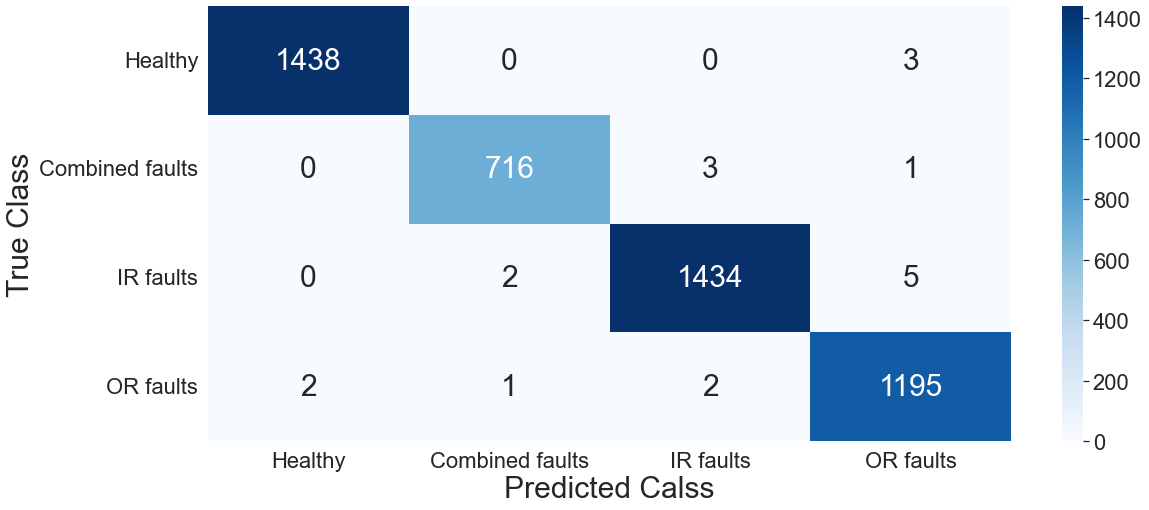

In [17]:
test_predictions = best_clf.predict(test_data_scaled)
test_confu_matrix = confusion_matrix(y_test, test_predictions)
fault_type = ['Healthy','Combined faults','IR faults','OR faults']
plt.figure(1,figsize=(18,8))
sns.set(font_scale=2)
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", annot_kws={"size": 30})
plt.xlabel('Predicted Calss', fontsize = 30)
plt.ylabel('True Class', fontsize = 30)
Accuracy = metrics.accuracy_score(y_test, test_predictions)
F1_score = metrics.f1_score(y_test, test_predictions, average='micro')
probs = best_clf.predict_proba(test_data_scaled)
lr_auc = roc_auc_score(y_test, probs, multi_class='ovr')
print('ROC AUC = %.3f' % (lr_auc))
print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")